In [23]:
# note Grakel does not seem to support Python >=3.10, Python 3.9 works fine
# you are free to remove imports that are not useful for you
from grakel.datasets import fetch_dataset
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import KernelPCA # to check your own implementation
from sklearn.manifold import TSNE
import numpy as np
from numpy.linalg import matrix_rank
import scipy
import matplotlib.pyplot as plt
import math

import sympy as sp
import pandas as pd
import seaborn as sns
import warnings
import cmath

In [2]:
# Some datasets, more datasets here https://ls11-www.cs.tu-dortmund.de/staff/morris/graphkerneldatasets

"""
    The MUTAG dataset consists of 188 chemical compounds divided into two 
    classes according to their mutagenic effect on a bacterium. 

    The chemical data was obtained form http://cdb.ics.uci.edu and converted 
    to graphs, where vertices represent atoms and edges represent chemical 
    bonds. Explicit hydrogen atoms have been removed and vertices are labeled
    by atom type and edges by bond type (single, double, triple or aromatic).
    Chemical data was processed using the Chemistry Development Kit (v1.4).
"""

"""
    ENZYMES is a dataset of protein tertiary structures obtained from (Borgwardt et al., 2005) 
    consisting of 600 enzymes from the BRENDA enzyme database (Schomburg et al., 2004). 
    In this case the task is to correctly assign each enzyme to one of the 6 EC top-level 
    classes. 
"""

"""
    NCI1 and NCI109 represent two balanced subsets of datasets of chemical compounds screened 
    for activity against non-small cell lung cancer and ovarian cancer cell lines respectively
    (Wale and Karypis (2006) and http://pubchem.ncbi.nlm.nih.gov).
"""

dataset_mutag = fetch_dataset("MUTAG", verbose=False) # just replace by the name of the datasets you want "ENZYMES", "NCI1"
dataset_enzymes = fetch_dataset("ENZYMES", verbose=False) 
dataset_nci1 = fetch_dataset("NCI1", verbose=False) 

G_mutag, y_mutag = dataset_mutag.data, dataset_mutag.target
G_enzymes, y_enzymes = dataset_enzymes.data, dataset_enzymes.target
G_nci1, y_nci1 = dataset_nci1.data, dataset_nci1.target


In [3]:
# Splits the dataset into a training and a test set
# G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.2, random_state=42)

In [4]:
# 4.1.2 Compute the kernels
gk_1 = WeisfeilerLehman(n_iter=10, base_graph_kernel=VertexHistogram, normalize=True)
K_mutag = gk_1.fit_transform(G_mutag)

gk_2 = WeisfeilerLehman(n_iter=10, base_graph_kernel=VertexHistogram, normalize=True)
K_enzymes = gk_1.fit_transform(G_enzymes)

gk_3 = WeisfeilerLehman(n_iter=10, base_graph_kernel=VertexHistogram, normalize=True)
K_nci1 = gk_1.fit_transform(G_nci1)

print("================ The kernel matrix for MUTAG dataset is: ================")
print("Shape:", K_mutag.shape)
print(K_mutag)
print("=============== The kernel matrix for ENZYMES dataset is: ===============")
print("Shape:", K_enzymes.shape)
print(K_enzymes)
print("================ The kernel matrix for NCI1 dataset is: =================")
print("Shape:", K_nci1.shape)
print(K_nci1)

================ The kernel matrix for MUTAG dataset is: ================
Shape: (188, 188)
[[1.         0.57509215 0.56413802 ... 0.55589197 0.71673825 0.64498003]
 [0.57509215 1.         0.5513308  ... 0.51454723 0.54701457 0.56085824]
 [0.56413802 0.5513308  1.         ... 0.52679836 0.53859896 0.57635157]
 ...
 [0.55589197 0.51454723 0.52679836 ... 1.         0.52197292 0.59571429]
 [0.71673825 0.54701457 0.53859896 ... 0.52197292 1.         0.61896063]
 [0.64498003 0.56085824 0.57635157 ... 0.59571429 0.61896063 1.        ]]
=============== The kernel matrix for ENZYMES dataset is: ===============
Shape: (600, 600)
[[1.         0.58845372 0.58161065 ... 0.5508986  0.63145753 0.59481709]
 [0.58845372 1.         0.53959038 ... 0.50167845 0.58340193 0.55308598]
 [0.58161065 0.53959038 1.         ... 0.42261408 0.54549444 0.51226803]
 ...
 [0.5508986  0.50167845 0.42261408 ... 1.         0.6492513  0.63026702]
 [0.63145753 0.58340193 0.54549444 ... 0.6492513  1.         0.75188966]
 [

In [29]:
# 4.1.4 Explicit embedding versus kernel
rank_mutag = matrix_rank(K_mutag)
rank_enzymes = matrix_rank(K_enzymes)
rank_nci1 = matrix_rank(K_nci1)

print("rank(" + "K_mutag" + ") =", rank_mutag)
print("rank(" + "K_enzymes" + ") =", rank_enzymes)
print("rank(" + "K_nci1" + ") =", rank_nci1)

rank(K_mutag) = 175
rank(K_enzymes) = 595
rank(K_nci1) = 4002


In [5]:
# 4.2.2 kernel-PCA implementation 

def decompose(K):
    K_matrix = K
#     eigval, eigvec = eigen_val_vec(K_matrix)
    eigval, eigvec = np.linalg.eig(K_matrix)
#     if not is_pos_semidef(eigval):
#         warnings.warn("The kernel matrix is not positive semi definitive!")
    # Normalize eigenvectors and compute singular values of K
    tuple_eig = [(np.sqrt(eigval[i]), eigvec[:,i] / cmath.sqrt(eigval[i])) for i in range(len(eigval))]
    tuple_eig.sort(key=lambda x: x[0], reverse=True)
    return tuple_eig

def is_pos_semidef(x):
    return np.all(x >= 0)  # if all the eigen values >= 0, then it's positive semi definitive

# def eigen_val_vec(matrix):
#     results = sp.Matrix(matrix).eigenvects()
#     eigval, eigvec = [], []

#     for result in results:
#         for _ in range(result[1]):
#             eigval.append(result[0])
#             eigvec.append(result[2][_].values())

#     eigval, eigvec = np.array(eigval, dtype='float64'), np.array(eigvec, dtype='float64').T

#     return eigval, eigvec

def projection(tuple_eig, n_components):
    tuples_eig_dim = tuple_eig[:n_components]
    sigma = np.diag([i[0] for i in tuples_eig_dim])
    v = np.array([list(j[1]) for j in tuples_eig_dim]).T
    sigma = np.real_if_close(sigma, tol=1)
    v = np.real_if_close(v, tol=1)
    scores = sigma @ v.T

    return scores

In [6]:
def get_scores_kpca(K):    
    K_matrix = K
    one_mat = np.ones(K_matrix.shape) / K_matrix.shape[1]
    K_tilde = K_matrix - one_mat @ K_matrix - K_matrix @ one_mat + one_mat @ K_matrix @ one_mat
    tuple_eig = decompose(K_tilde)
    scores = projection(tuple_eig, 2)
    
    return scores

In [7]:
scores_mutag = get_scores_kpca(K_mutag)
scores_enzymes = get_scores_kpca(K_enzymes)
scores_nci1 = get_scores_kpca(K_nci1)

/Users/maurice/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/maurice/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/maurice/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


In [11]:
# 4.2.3 kernel-PCA visualization
def plot_2d(x_1, x_2, classes, plot_title, x_label, y_label):
    plot_data = pd.DataFrame([x_1, x_2, classes]).T
    plot_data.columns = ['x_1', 'x_2', 'class']
    
    sns.set_context('notebook', font_scale=1.1)
    sns.set_style('ticks')
#     fig = plt.figure(figsize =(16, 10), dpi=200)
    sns.lmplot(x='x_1',
              y='x_2',
              data=plot_data,
              fit_reg=False,
              legend=True,
              height=9,
              hue='class',
              scatter_kws={"s":200, "alpha":0.3})
    
#     plt.legend(['y$=$-1', 'y$=$1'] ,title="Class")
    plt.title(plot_title, weight='bold').set_fontsize(14)
    plt.xlabel(x_label, weight='bold').set_fontsize(10)
    plt.ylabel(y_label, weight='bold').set_fontsize(10)
    plt.show()

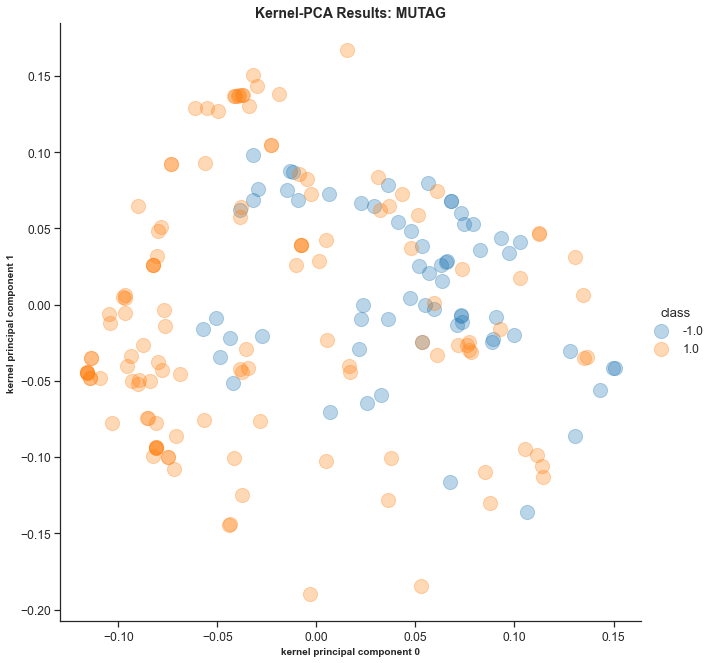

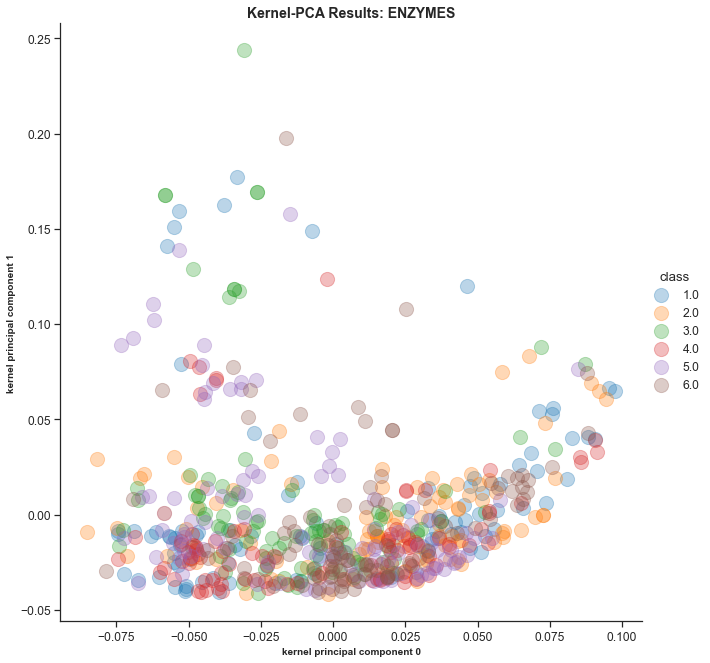

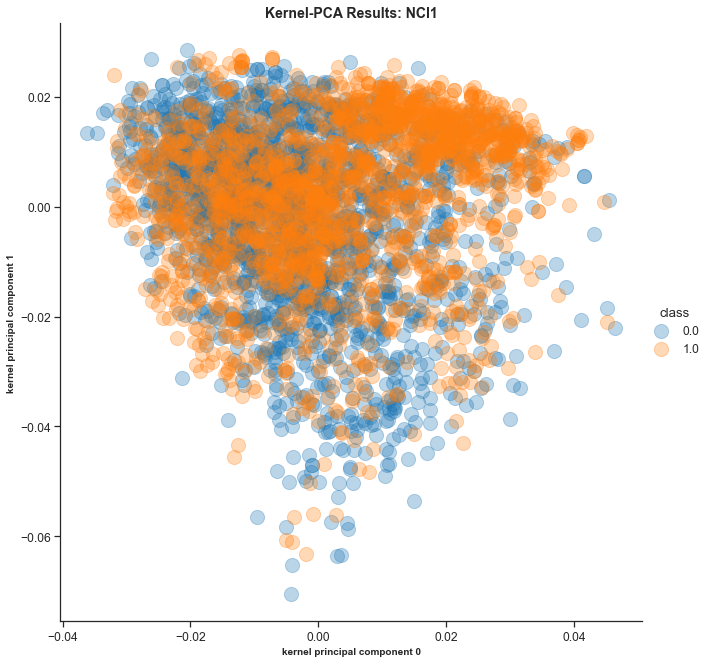

In [12]:
# 4.2.3 kernel-PCA visualization
# colors = ['g' if i == 1 else 'b' for i in y]

def plot_2d_dataset(scores, y, dataset):
    plot_2d(scores[0, :], scores[1, :], y, 
            'Kernel-PCA Results: ' + dataset,
            'kernel principal component 0', 
            'kernel principal component 1')
    
plot_2d_dataset(scores_mutag, y_mutag, 'MUTAG')
plot_2d_dataset(scores_enzymes, y_enzymes, 'ENZYMES')
plot_2d_dataset(scores_nci1, y_nci1, 'NCI1')

In [16]:
# 4.2.4 Distance
def distance(K):
    pair_dist_lists = []
    for i in range(K.shape[0]):
        pair_dist_list = []
        for j in range(K.shape[0]):
            pair_dist_list.append(np.sqrt(K[i, i] + K[j, j] - 2*K[i, j]))
        pair_dist_lists.append(pair_dist_list)
    d_pairwise = np.array(pair_dist_lists)
#     display(d_pairwise)
    return d_pairwise

d_pairwise_mutag = distance(K_mutag)
d_pairwise_enzymes = distance(K_enzymes)
d_pairwise_nci1 = distance(K_nci1)

print("================ The pairwise distance for MUTAG dataset is: ================")
print(d_pairwise_mutag)
print("================ The pairwise distance for ENZYMES dataset is: ================")
print(d_pairwise_enzymes)
print("================ The pairwise distance for NCI1 dataset is: ================")
print(d_pairwise_nci1)

================ The pairwise distance for MUTAG dataset is: ================
[[0.         0.92185449 0.93366159 ... 0.94245215 0.75267756 0.84263867]
 [0.92185449 0.         0.94727947 ... 0.98534539 0.95182502 0.93716781]
 [0.93366159 0.94727947 0.         ... 0.97283261 0.96062588 0.9204873 ]
 ...
 [0.94245215 0.98534539 0.97283261 ... 0.         0.97778022 0.899206  ]
 [0.75267756 0.95182502 0.96062588 ... 0.97778022 0.         0.87297121]
 [0.84263867 0.93716781 0.9204873  ... 0.899206   0.87297121 0.        ]]
================ The pairwise distance for ENZYMES dataset is: ================
[[0.         0.90724449 0.91475609 ... 0.94773562 0.85853651 0.90020321]
 [0.90724449 0.         0.95959327 ... 0.99832014 0.91279578 0.94542479]
 [0.91475609 0.95959327 0.         ... 1.07460311 0.95342074 0.98765578]
 ...
 [0.94773562 0.99832014 1.07460311 ... 0.         0.83755442 0.85992206]
 [0.85853651 0.91279578 0.95342074 ... 0.83755442 0.         0.70442933]
 [0.90020321 0.94542479 0.98

In [18]:
# 4.2.5 tSNE
d_pairwise_embedded_mutag = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(d_pairwise_mutag)
# d_pairwise_embedded_mutag.shape

d_pairwise_embedded_enzymes = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(d_pairwise_enzymes)
# d_pairwise_embedded_enzymes.shape

d_pairwise_embedded_nci1 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(d_pairwise_nci1)
# d_pairwise_embedded_nci1.shape


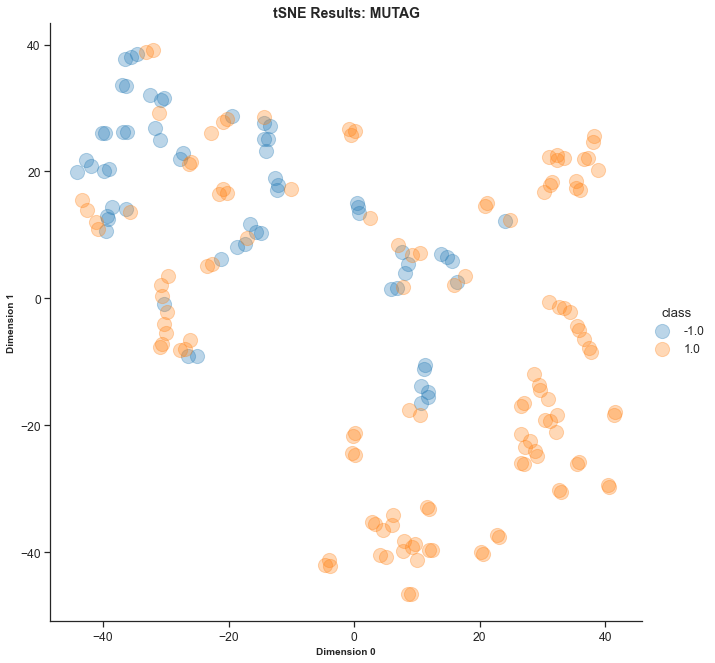

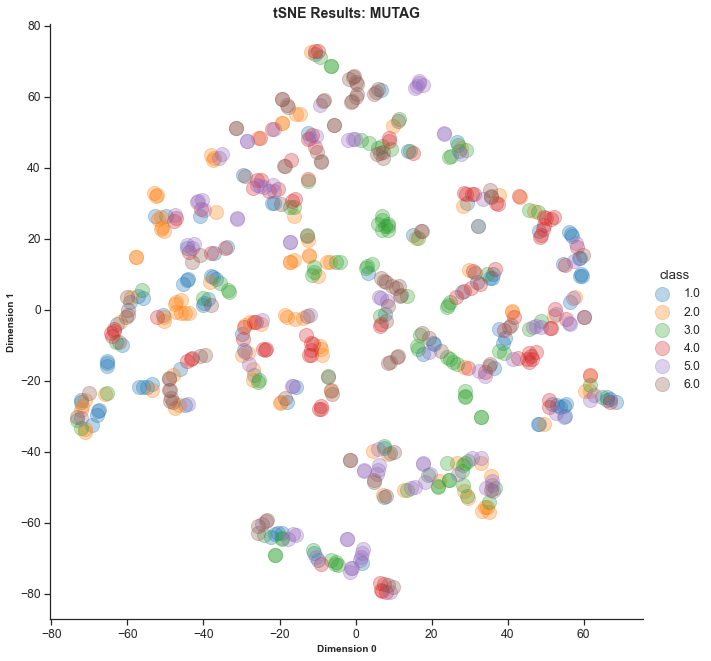

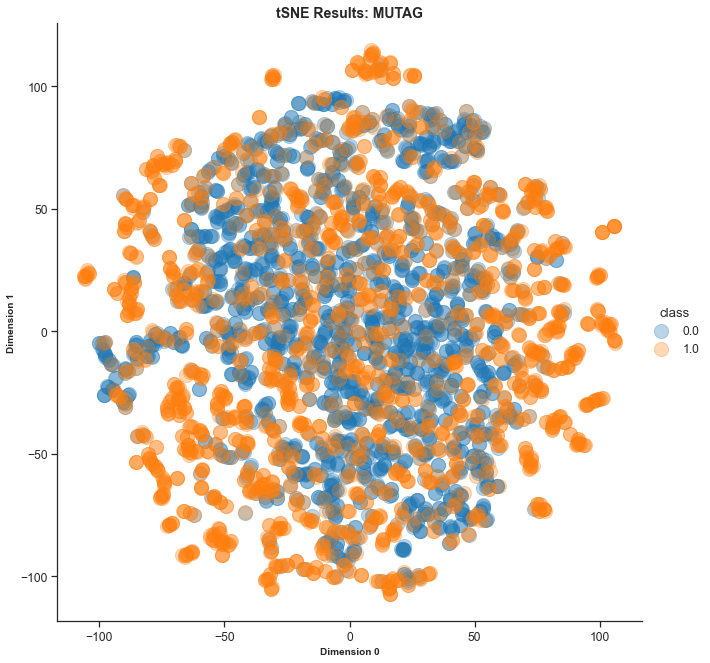

In [20]:
# tSNE visualization
def plot_2d_tsne(d_pairwise_embedded, y, dataset):
    plot_2d(d_pairwise_embedded[:, 0], d_pairwise_embedded[:, 1], y, 
            'tSNE Results: MUTAG',
            'Dimension 0', 
            'Dimension 1')
    
plot_2d_tsne(d_pairwise_embedded_mutag, y_mutag, 'MUTAG')
plot_2d_tsne(d_pairwise_embedded_enzymes, y_enzymes, 'ENZYMES')
plot_2d_tsne(d_pairwise_embedded_nci1, y_nci1, 'NCI1')